In [3]:
using MatrixNetworks
using Distributions
using Gadfly
using Clustering
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using LinearAlgebra
using EllipsoidalGraphEmbedding
using Random
using Plots
using LaTeXStrings

┌ Info: Precompiling SphericalGraphEmbedding [abe9faeb-2622-484d-8e33-db466c9fd899]
└ @ Base loading.jl:1342


In [19]:
# Loading data
m = readdlm("Data/PowerEU/ElistPowerEU.txt");
dim = size(m,1);

M_int = zeros(Int64,dim,2);
for i =1:dim
	for j=1:2
		M_int[i,j] = Int64(m[i,j]);
	end
end

N = maximum([maximum(M_int[:,1]),maximum(M_int[:,2])]);

A0 =spzeros(N,N);
A0 = sparse(M_int[:,1],M_int[:,2],vec(ones(Int64,dim,1)),N,N);
A0 = A0+A0';
A,p = largest_component(A0);

A0=0;p=0;m =0;

# nb iterations projected power method
n_it_PPM = 30000;

# relative objective variation
t = 1e-8;

r0 = 10

N = size(A, 1)
d = sum(A, dims=2)
s = sum(d)

# ROW NORMALIZATION 
index = sample(1:N, r0; replace=false, ordered=true)
H0 = A[:, index] - (1 / s) * d * d[index]'

# Project on the sphere
H0 = H0./sqrt.(sum(abs2, H0, dims=2));
X = H0

# GPMM
# Initialization
f = vec(1 .+ 2 * d - (d .^ 2) / s)

i = 1
diff = 10.0

Y0 = zeros(size(X))
Y = zeros(size(X))

obj_0 = 1.0
obj = 1.0
r = 0.0

n_it = 50
objective_GPMM = zeros(n_it,1)

while (i <= n_it) 

    # Matrix product
    Y = A * X - (d / s) * (d' * X) + Diagonal(f) * X
    # In order to avoid calculating twice the same products
    # Since X is feasible, we calculate the objective value AFTER the first matrix product.
    obj = (tr(X' * Y)) / s
    objective_GPMM[i] = obj
    #Difference between consecutive objectives
    diff = abs.(obj - obj_0) / obj_0

    #Update with momentum
    r = (i - 1.0) / (i + 2.0)
    X = (1 + r) * Y
    X = X - r * Y0

    #Project on the sphere
    X = X ./ sqrt.(sum(abs2, X, dims=2))

    #Update objective and momentum
    obj_0 = obj

    Y0 = Y
    i += 1
end



X = H0
# GPM
# Initialization
# Initialization
i = 1
diff = 10.0

Y0 = zeros(size(X))
Y = zeros(size(X))

obj_0 = 1.0
obj = 1.0
r = 0.0

n_it = 50
objective_GPM = zeros(n_it,1)

while (i <= n_it) 

    # Matrix product
    Y = A * X - (d / s) * (d' * X) + Diagonal(f) * X
    # In order to avoid calculating twice the same products
    # Since X is feasible, we calculate the objective value AFTER the first matrix product.
    obj = (tr(X' * Y)) / s
    objective_GPM[i] = obj
    #Difference between consecutive objectives
    diff = abs.(obj - obj_0) / obj_0

    #Update with momentum HERE CHANGE
    r = 0
    X = (1 + r) * Y
    X = X - r * Y0

    #Project on the sphere
    X = X ./ sqrt.(sum(abs2, X, dims=2))

    #Update objective and momentum
    obj_0 = obj

    Y0 = Y
    i += 1
end

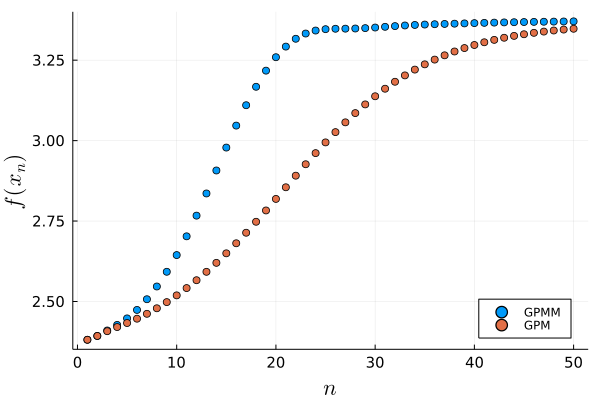

In [30]:
p2 = Plots.plot(1:length(objective_GPMM),objective_GPMM, label = "GPMM" ,seriestype=:scatter)
Plots.plot!(1:length(objective_GPM),objective_GPM, label = "GPM",seriestype=:scatter,legend=:bottomright,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15)
xlabel!(L"n")
ylabel!(L"f(x_n)")
savefig("figures/PPM_momentum_PowerEU.pdf")
display(p2)